In [4]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [5]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 60
PATIENCE_ES = 25
BATCH_SIZE = 32

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 🎯 Fine-tuning VGG16 para Clasificación de Cartas

Este notebook implementa fine-tuning de **VGG16** siguiendo el patrón establecido en los notebooks anteriores.

## 📋 Estructura:

1. **Setup y Data Augmentation**
2. **Construcción del modelo VGG16 mejorado**
3. **Entrenamiento con callbacks optimizados**
4. **Evaluación y comparación**
5. **Análisis detallado** (Classification report y confusion matrix)

## 🚀 Configuración:

- ✅ **VGG16** pre-entrenado en ImageNet
- ✅ **Descongelamiento gradual** de capas convolucionales
- ✅ **Data augmentation balanceada**
- ✅ **Regularización L2** y **Dropout**
- ✅ **BatchNormalization** en capas densas
- ✅ **AdamW optimizer** con weight decay
- ✅ **Label smoothing** 0.1

---

## Cargar datos con Data Augmentation

In [6]:
# Data augmentation balanceada para VGG16
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.95, 1.05),
    channel_shift_range=10
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7729 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Construir modelo VGG16 con fine-tuning

In [7]:
# Cargar VGG16 pre-entrenado
base_vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(SIZE, SIZE, 3)
)

print(f'Total capas en VGG16: {len(base_vgg16.layers)}')

# Estrategia de descongelamiento: descongelar últimas capas convolucionales
# VGG16 tiene 5 bloques convolucionales, descongelamos los últimos 2 (block4 y block5)
for layer in base_vgg16.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

trainable_count = sum([1 for layer in base_vgg16.layers if layer.trainable])
print(f'Capas entrenables: {trainable_count}')
print(f'Capas congeladas: {len(base_vgg16.layers) - trainable_count}')

58889256/58889256 [==============================] - 5s 0us/step
Total capas en VGG16: 19
Capas entrenables: 8
Capas congeladas: 11
Total capas en VGG16: 19
Capas entrenables: 8
Capas congeladas: 11


In [8]:
# Arquitectura mejorada con BatchNormalization y regularización
inputs = tf.keras.layers.Input(shape=(SIZE, SIZE, 3))
x = base_vgg16(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Mejor que Flatten para reducir parámetros
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.5)(x)  # VGG suele beneficiarse de dropout más alto
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

vgg16_model = tf.keras.Model(inputs=inputs, outputs=outputs)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
_____________________________________________________________

In [9]:
# Contar parámetros
trainable_params = np.sum([np.prod(v.shape) for v in vgg16_model.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in vgg16_model.non_trainable_variables])
print(f'Parámetros entrenables: {trainable_params:,}')
print(f'Parámetros no entrenables: {non_trainable_params:,}')
print(f'Total: {trainable_params + non_trainable_params:,}')

Parámetros entrenables: 13,414,965
Parámetros no entrenables: 1,737,536
Total: 15,152,501


## Configurar callbacks y compilar

In [10]:
name = 'VGG16_finetuned'

# Callbacks mejorados
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

csv_logger = tf.keras.callbacks.CSVLogger(
    os.path.join(path_results, name + '_training_log.csv'),
    separator=',',
    append=False
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard, csv_logger]

In [11]:
# Compilar con AdamW y label smoothing
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,  # Learning rate conservador para fine-tuning
    weight_decay=1e-5
)

# Label smoothing para mejor generalización
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

vgg16_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

## Entrenar modelo

In [ ]:
print(f'\n{"="*60}')
print(f'ENTRENANDO VGG16 CON FINE-TUNING')
print(f'{"="*60}\n')

history = vgg16_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    callbacks=callbacks_list,
    verbose=1
)


ENTRENANDO VGG16 CON FINE-TUNING

Epoch 1/10
Epoch 1/10
242/242 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.9647
Epoch 1: val_accuracy did not improve from 0.99245

Epoch 1: val_accuracy did not improve from 0.99245
242/242 [==============================] - 75s 308ms/step - loss: 1.0439 - accuracy: 0.9647 - val_loss: 0.9104 - val_accuracy: 0.9849 - lr: 5.0000e-05
Epoch 2/10
242/242 [==============================] - 75s 308ms/step - loss: 1.0439 - accuracy: 0.9647 - val_loss: 0.9104 - val_accuracy: 0.9849 - lr: 5.0000e-05
Epoch 2/10
242/242 [==============================] - ETA: 0s - loss: 1.0350 - accuracy: 0.9674
Epoch 2: val_accuracy did not improve from 0.99245

Epoch 2: val_accuracy did not improve from 0.99245
242/242 [==============================] - 70s 289ms/step - loss: 1.0350 - accuracy: 0.9674 - val_loss: 0.9079 - val_accuracy: 0.9887 - lr: 5.0000e-05
Epoch 3/10
242/242 [==============================] - 70s 289ms/step - loss: 1.0350 - accura

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 75s 308ms/step - loss: 1.0294 - accuracy: 0.9689 - val_loss: 0.8898 - val_accuracy: 0.9962 - lr: 5.0000e-05
Epoch 6/10
Epoch 6/10
242/242 [==============================] - ETA: 0s - loss: 1.0305 - accuracy: 0.9677
Epoch 6: val_accuracy did not improve from 0.99623

Epoch 6: val_accuracy did not improve from 0.99623
242/242 [==============================] - 69s 286ms/step - loss: 1.0305 - accuracy: 0.9677 - val_loss: 0.9132 - val_accuracy: 0.9849 - lr: 5.0000e-05
Epoch 7/10
242/242 [==============================] - 69s 286ms/step - loss: 1.0305 - accuracy: 0.9677 - val_loss: 0.9132 - val_accuracy: 0.9849 - lr: 5.0000e-05
Epoch 7/10
242/242 [==============================] - ETA: 0s - loss: 1.0278 - accuracy: 0.9723
Epoch 7: val_accuracy did not improve from 0.99623

Epoch 7: val_accuracy did not improve from 0.99623
242/242 [==============================] - 76s 314ms/step - loss: 1.0278 - accuracy: 0.9723 - val_loss: 0.9027 - val_accuracy: 

## Visualizar resultados

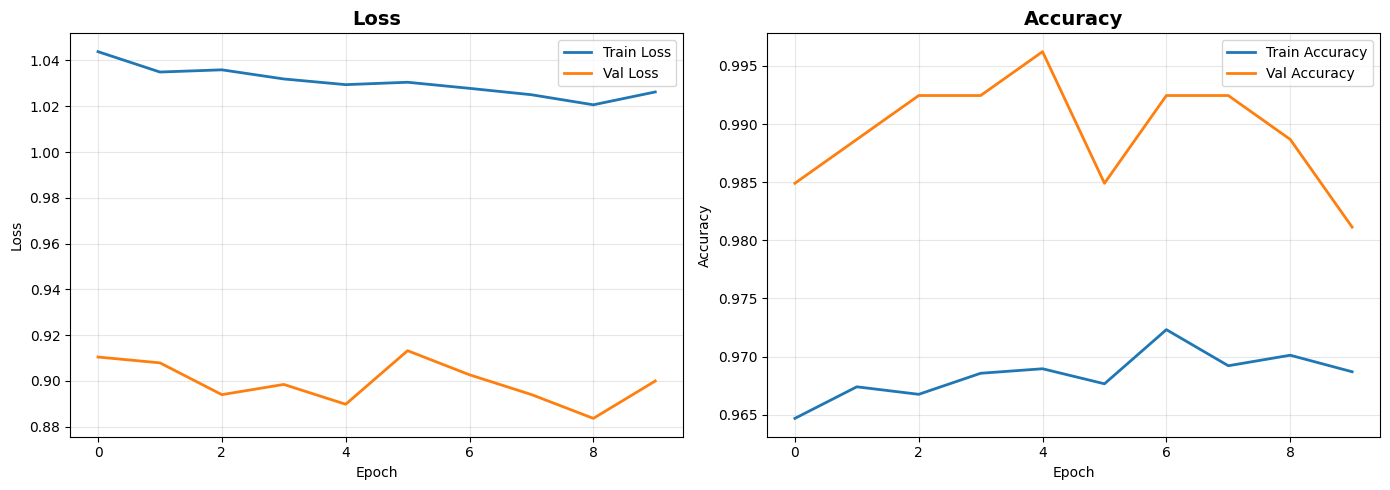

In [ ]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

plot_and_save(history, path_results, name)

## Evaluación en Test Set

In [ ]:
# Cargar mejor modelo
best_model = tf.keras.models.load_model(os.path.join(path_models, name + '.h5'))

# Evaluar
print(f'\n{"="*60}')
print('EVALUANDO VGG16 EN TEST SET')
print(f'{"="*60}\n')

_, acc_vgg16 = best_model.evaluate(test_dataset, verbose=1)

print(f'\n{"="*60}')
print(f'RESULTADO FINAL')
print(f'{"="*60}')
print(f'VGG16 Fine-tuned Accuracy: {acc_vgg16:.4f} ({acc_vgg16*100:.2f}%)')
print(f'{"="*60}')


EVALUANDO VGG16 EN TEST SET

9/9 [==============================] - 2s 203ms/step - loss: 0.9136 - accuracy: 0.9887

RESULTADO FINAL
VGG16 Fine-tuned Accuracy: 0.9887 (98.87%)
9/9 [==============================] - 2s 203ms/step - loss: 0.9136 - accuracy: 0.9887

RESULTADO FINAL
VGG16 Fine-tuned Accuracy: 0.9887 (98.87%)


## Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe, name='Model'):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    
    fig, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(cf, annot=True, square=True, cbar=True, fmt='',
                cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array,
                ax=ax, linewidths=0.1)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, f'{name}_confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()

print(f'\n{"="*60}')
print(f'CLASSIFICATION REPORT: {name}')
print(f'{"="*60}\n')
show_report(best_model, test_dataset)


CLASSIFICATION REPORT: VGG16_finetuned

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      1.00      1.00         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      0.80      0.89         5
   four of spa

## Confusion Matrix

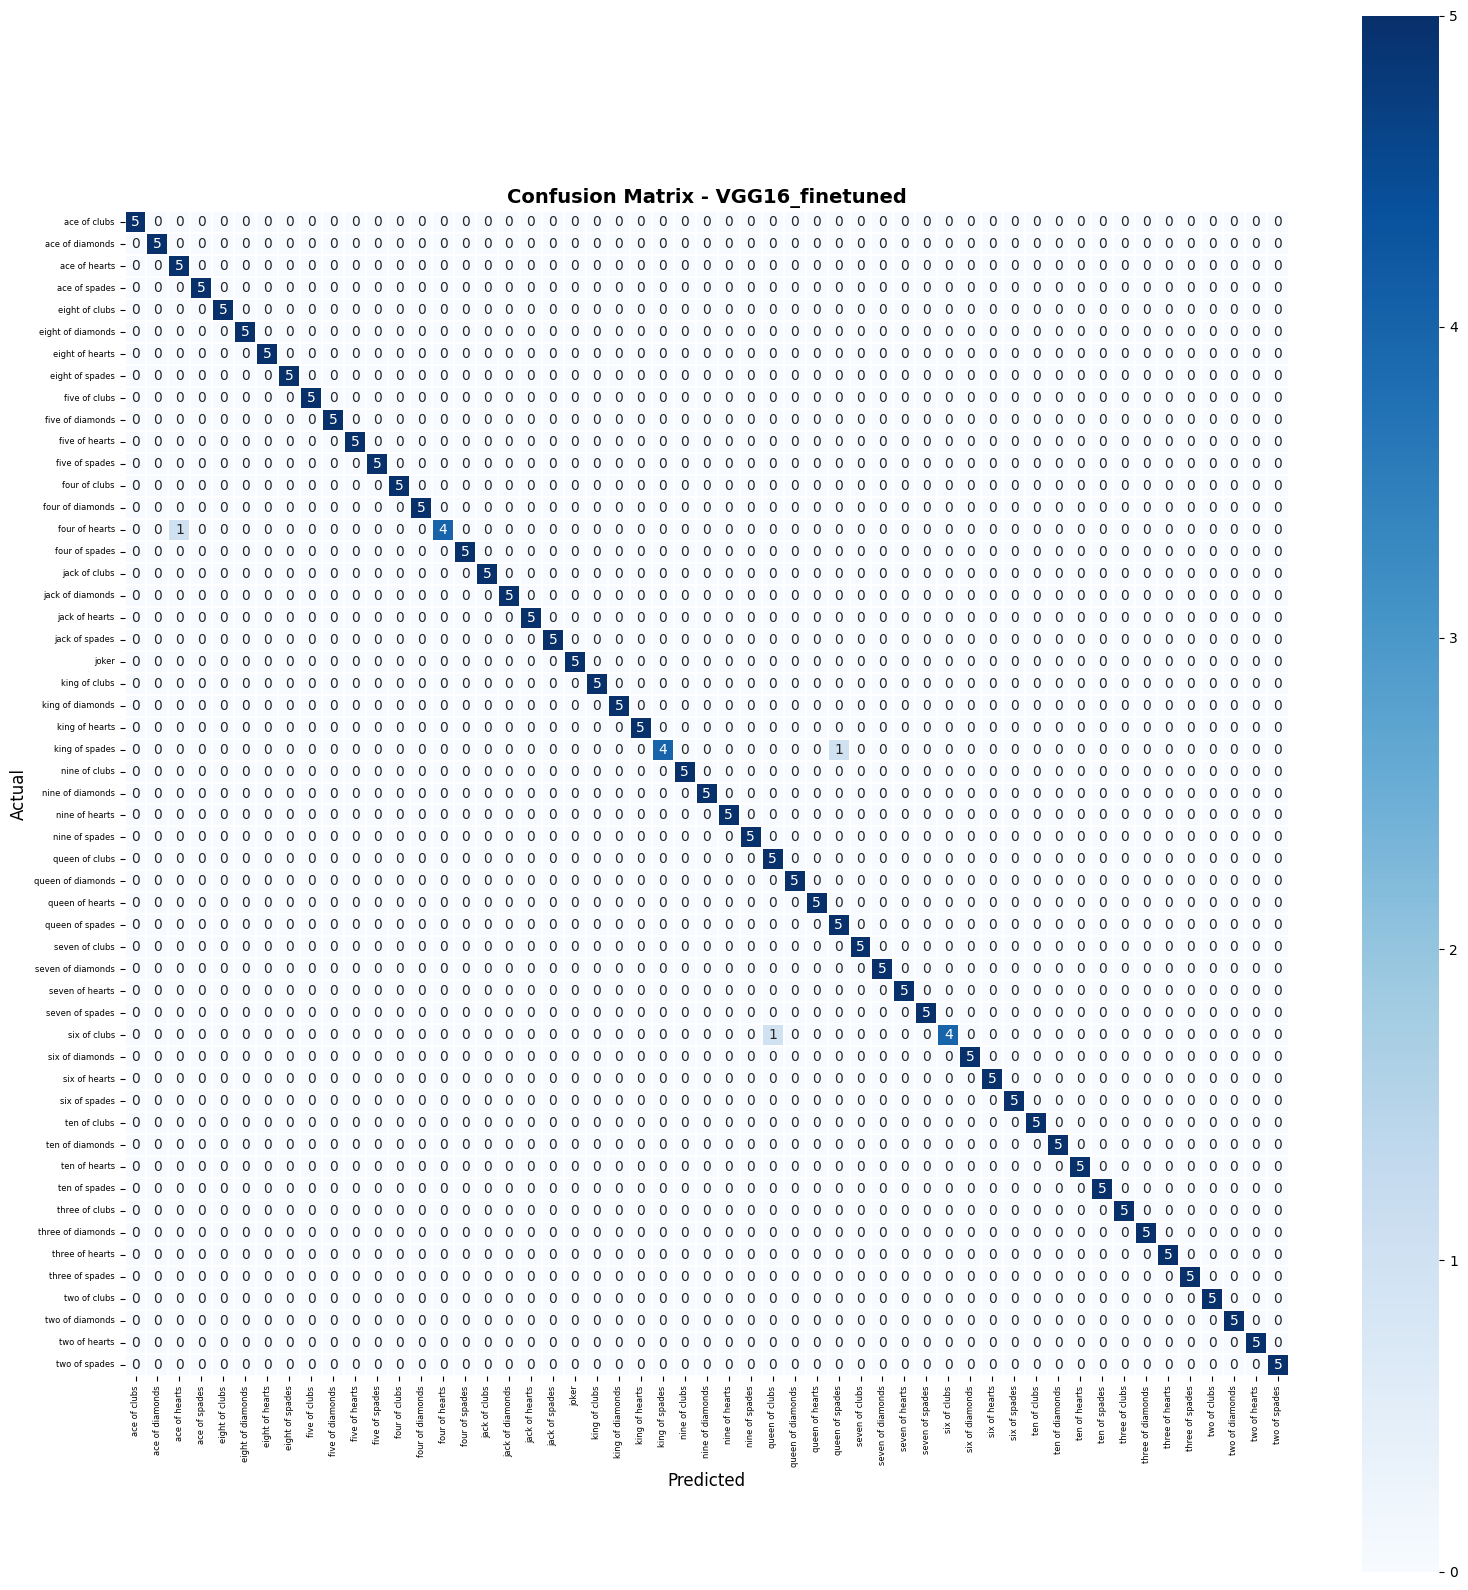

In [ ]:
show_matrix(best_model, test_dataset, name)

## Análisis de predicciones (top-5 accuracy)

In [ ]:
# Calcular top-5 accuracy
predictions = best_model.predict(test_dataset, verbose=0)
true_labels = test_dataset.labels

# Top-5 predictions
top5_pred = tf.math.top_k(predictions, k=5).indices.numpy()

# Calcular top-5 accuracy
top5_correct = sum([true_labels[i] in top5_pred[i] for i in range(len(true_labels))])
top5_acc = top5_correct / len(true_labels)

print(f'\nTop-1 Accuracy: {acc_vgg16:.4f} ({acc_vgg16*100:.2f}%)')
print(f'Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)')

## Comparación con otros modelos (si existen)

In [ ]:
# Intentar cargar otros modelos para comparación
models_comparison = {'VGG16': acc_vgg16}

# MobileNet
try:
    mn_model = tf.keras.models.load_model('Models/MobileNet_3.h5')
    _, acc_mn = mn_model.evaluate(test_dataset, verbose=0)
    models_comparison['MobileNet'] = acc_mn
except:
    print('MobileNet_3 no encontrado')

# Custom CNN
try:
    custom_model = tf.keras.models.load_model('Models/Custom_4.h5')
    _, acc_custom = custom_model.evaluate(test_dataset, verbose=0)
    models_comparison['Custom_4'] = acc_custom
except:
    print('Custom_4 no encontrado')

# ViT
try:
    from vit_keras import vit, layers as vit_layers
    custom_objects = {}
    for name_obj in dir(vit_layers):
        obj = getattr(vit_layers, name_obj)
        if isinstance(obj, type):
            custom_objects[name_obj] = obj
    vit_model = tf.keras.models.load_model('Models/ViT_B16_3.h5', custom_objects=custom_objects)
    _, acc_vit = vit_model.evaluate(test_dataset, verbose=0)
    models_comparison['ViT_B16'] = acc_vit
except:
    print('ViT_B16_3 no encontrado')

# Gráfico comparativo
if len(models_comparison) > 1:
    fig, ax = plt.subplots(figsize=(12, 7))
    colors = plt.cm.Set3(range(len(models_comparison)))
    bars = ax.bar(models_comparison.keys(), models_comparison.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Comparación de Modelos en Test Set', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0.7, 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
    ax.set_axisbelow(True)
    
    # Añadir valores sobre las barras
    for bar, (model_name, acc) in zip(bars, models_comparison.items()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{acc:.4f}\n({acc*100:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, 'models_comparison_with_vgg16.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Tabla de comparación
    print(f'\n{"="*60}')
    print('COMPARACIÓN DE TODOS LOS MODELOS')
    print(f'{"="*60}')
    for model_name, acc in sorted(models_comparison.items(), key=lambda x: x[1], reverse=True):
        print(f'{model_name:<20} {acc:.4f} ({acc*100:.2f}%)')
    print(f'{"="*60}')
else:
    print(f'\nSolo VGG16 disponible. Accuracy: {acc_vgg16:.4f} ({acc_vgg16*100:.2f}%)')

## Resumen y Conclusiones

In [ ]:
print(f'\n{"="*70}')
print(' '*20 + 'RESUMEN - VGG16 FINE-TUNING')
print(f'{"="*70}')

print(f'\n📊 MÉTRICAS FINALES:')
print(f'  - Test Accuracy: {acc_vgg16:.4f} ({acc_vgg16*100:.2f}%)')
print(f'  - Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)')

print(f'\n🔧 CONFIGURACIÓN:')
print(f'  - Modelo base: VGG16 (ImageNet)')
print(f'  - Capas descongeladas: block4 y block5')
print(f'  - Optimizer: AdamW (lr=1e-4, weight_decay=1e-5)')
print(f'  - Loss: CrossEntropy + Label Smoothing (0.1)')
print(f'  - Regularización: L2 (1e-4) + Dropout (0.3-0.5)')
print(f'  - Batch size: {BATCH_SIZE}')
print(f'  - Épocas máximas: {EPOCHS}')

print(f'\n📁 ARCHIVOS GENERADOS:')
print(f'  ✓ {name}.h5 - Mejor modelo guardado')
print(f'  ✓ {name}_training_log.csv - Log de entrenamiento')
print(f'  ✓ {name}_curves.png - Curvas de aprendizaje')
print(f'  ✓ {name}_confusion_matrix.png - Matriz de confusión')

print(f'\n{"="*70}')